In [1]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

In [141]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    return IPython.display.HTML(animation.to_jshtml())

In [442]:
bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

i = 6 # rider
f1 = bicycle_record_files[i]
f2 = lidar_record_files[i]

with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

data_dir = '../../data/comfort/'
bicycle_rec = load_file(
    os.path.join(data_dir, f1),
    bicycle_calibration['convbike'])
lidar_rec = load_converted_record(
    os.path.join(data_dir, f2))

r = Record(lidar_rec, bicycle_rec)
r.sync()

ValueError: ('Unable to synchronize signals {}, {}', <antlia.record.SampledTimeSignal object at 0x113f26eb8>, <antlia.record.SampledTimeSignal object at 0x113f26e80>)

In [449]:
r.sync()

-17.519999999999982

<IPython.core.display.Javascript object>


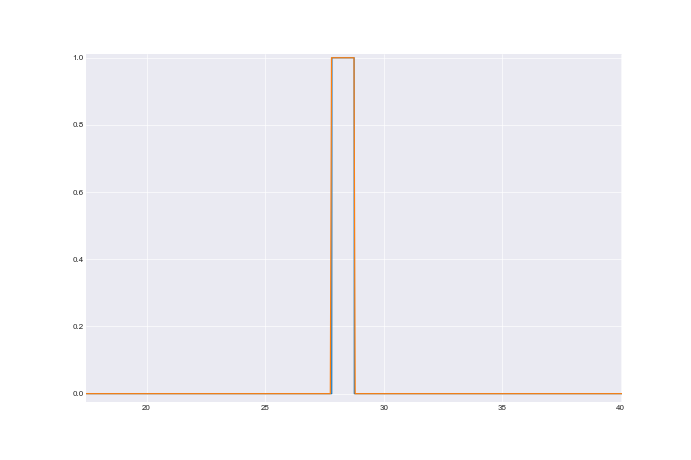

In [450]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot(r.bicycle.time, r.bicycle.sync)
ax.plot(r.lidar.time, r.lidar.sync)
plt.show()

In [451]:
#r._calculate_trials2(lidar_bbmask={'xlim': (3.8, 4.4), 'ylim': (2.9, 3.4)})
#r._calculate_trials2(trial_mask=0)
#r._calculate_trials2(missing_sync=[680])
r._calculate_trials2()

<IPython.core.display.Javascript object>


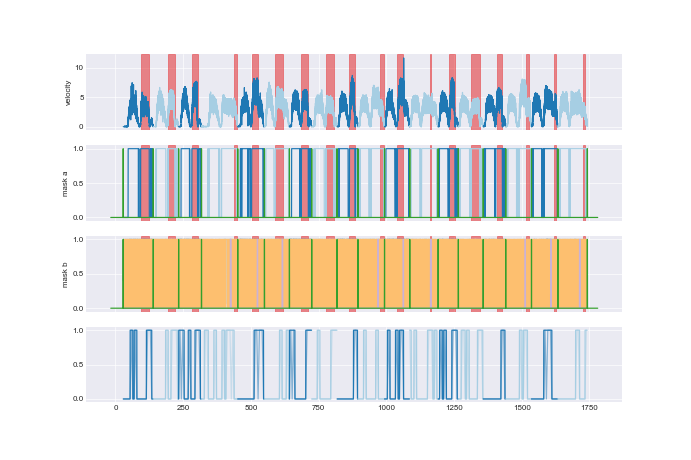

In [452]:
DEFAULT_FIGSIZE = (12, 8)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib notebook

plt.close()
colors = sns.color_palette('Paired', 12)
fig, ax = plt.subplots(4, 1, sharex=True)

i = 0
for t in r.trials:
    i = i ^ 1
    ax[0].plot(t.data.time, t.data.speed, color=colors[i])
    
    ax[1].plot(t.data.time, t.event_detection.mask_a, color=colors[i])
    ax[2].plot(t.data.time, t.event_detection.mask_b, color=colors[i])
    
    t0, t1 = t.event.bicycle.time[[0, -1]]
    ax[0].axvspan(t0, t1, color=colors[5], alpha=0.5)
    ax[1].axvspan(t0, t1, color=colors[5], alpha=0.5)
    ax[2].axvspan(t0, t1, color=colors[5], alpha=0.5)
    
    # cyclist enters from right
    ax[2].plot(t.lidar.time,
               t.lidar.cartesian(xlim=(20, 50), ylim=(2, 4))[0].count(axis=1) > 1,
               color=colors[6])
    
    # cyclist exist at left
    ax[2].plot(t.lidar.time,
               t.lidar.cartesian(xlim=(-20, -10), ylim=(2, 4))[0].count(axis=1) > 1,
               color=colors[8])
    
    lidar_subsample = t.lidar[::100]
    object_count = lidar_object_count(lidar_subsample, xlim=(-10, 30), ylim=(1, 4))
    ax[3].plot(lidar_subsample.time, object_count > 0, color=colors[i], alpha=0.5)
    
    count_interp = np.interp(t.data.time, lidar_subsample.time, object_count)
    ax[3].plot(t.data.time, count_interp > 0, color=colors[i])
    
ax[1].plot(r.bicycle.time, r.bicycle.sync, color=colors[3]) 
ax[2].plot(r.bicycle.time, r.bicycle.sync, color=colors[3]) 

ax[0].set_ylabel('velocity')
ax[1].set_ylabel('mask a')
ax[2].set_ylabel('mask b')

plt.show()

<IPython.core.display.Javascript object>


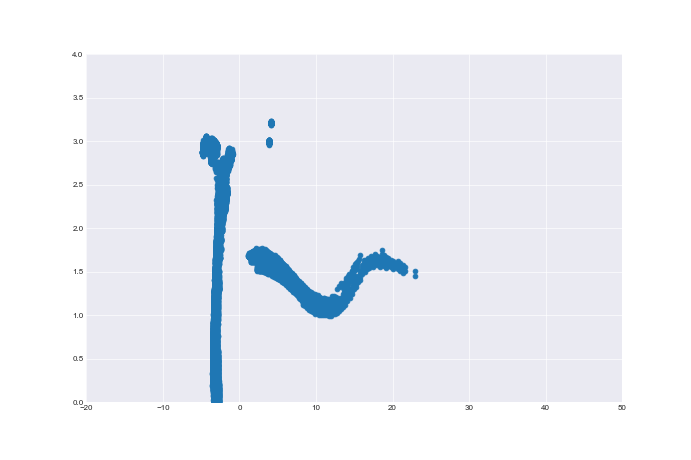

In [412]:
import hdbscan

plt.close('all')
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

#time = lambda t: (t >= 100) & (t < 140)
#time = 529
cart_kw = {'xlim': (-20, 50), 'ylim': (0, 4)}
#x, y = [z.compressed() for z in r.lidar.frame(time).cartesian(**cart_kw)]
x, y = [z.compressed() for z in r.trials[1].event.lidar.cartesian(**cart_kw)]
ax.scatter(x, y)

#X = np.vstack((x, y)).transpose()
#hdb = hdbscan.HDBSCAN(
#    min_cluster_size=10,
#    min_samples=10,
#    allow_single_cluster=True,
#    metric='euclidean').fit(X)
#hdb_unique_labels = set(hdb.labels_)
#
#colors = sns.husl_palette(len(hdb_unique_labels))
#for i in hdb_unique_labels:
#    index = hdb.labels_ == i
#    
#    alpha = 1
#    marker = 'o'
#    color = colors[i]
#    if i == -1:
#        alpha = 0.3
#        marker = '.'
#        color = (0.5, 0.5, 0.5)
#        
#    ax.scatter(x[index], y[index],
#               marker=marker, color=color, alpha=alpha)

ax.set_xlim(cart_kw['xlim'])
ax.set_ylim(cart_kw['ylim'])
plt.show()

In [421]:
DEAFAULT_FIGSIZE = (16, 12)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib inline

for trial in [r.trials[1]]:
    d = display_animation(trial.event.lidar.animate(
        xlim=(-40, 40),
        ylim=(0, 4),
        rlim=(0, 110),
        figsize=DEFAULT_FIGSIZE))
    IPython.display.display(d)

In [411]:
for i, t in enumerate(r.trials):
    print(i, t.event.type)
    #print(i, dict(t.event_detection._asdict()))
    print()

0 Braking

1 Braking

2 Braking

3 Overtaking

4 Overtaking

5 Overtaking

6 Braking

7 Braking

8 Braking

9 Overtaking

10 Overtaking

11 Overtaking

12 Braking

13 Braking

14 Braking

15 Overtaking

16 Overtaking

17 Overtaking



(array([ (-2.26920711,  314.44125201, -0.93996212,   6.57146684e-181,  0.04209919,  6.1296663,  3.080387,  10.2310823,  135.564916,  138.645303, 55, [14238, 14623], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.16305282, -0.17021901, -0.17760474, ..., -0.15559215,
       -0.1530471 , -0.14986796]), [])



<IPython.core.display.Javascript object>


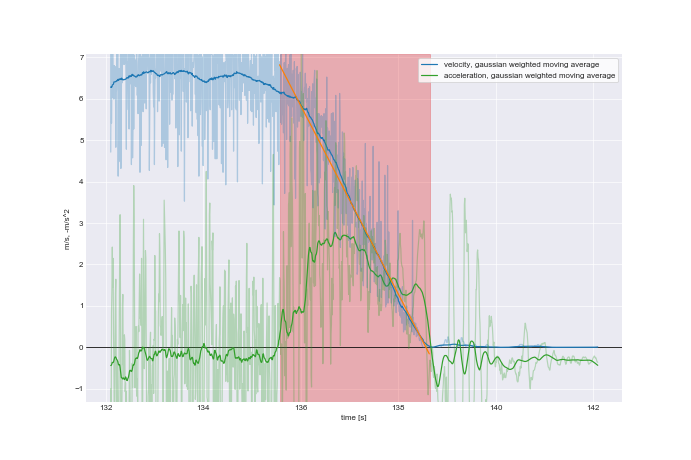

(array([ (-3.99884481,  887.58530681, -0.8576481,   3.88394693e-52,  0.18176663,  4.7910253,  1.408176,  3.29263264,  220.671615,  222.079791, 55, [8726, 8902], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.18112776, -0.18890349, -0.19654107, ..., -0.16017854,
       -0.15446488, -0.14929591]), [])



<IPython.core.display.Javascript object>


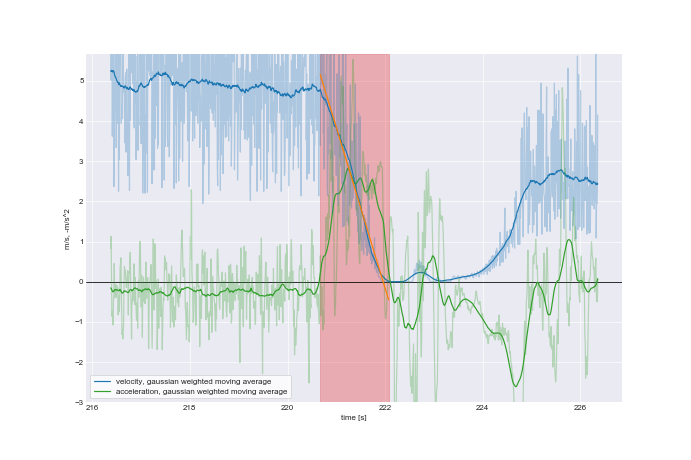

(array([ (-3.54542678,  1064.17433306, -0.87822941,   2.42632006e-83,  0.12114046,  6.18591136,  2.048258,  7.25904797,  298.130356,  300.178614, 55, [8338, 8594], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.13016729, -0.13524246, -0.14058466, ..., -0.17810392,
       -0.18065446, -0.18297738]), [])



<IPython.core.display.Javascript object>


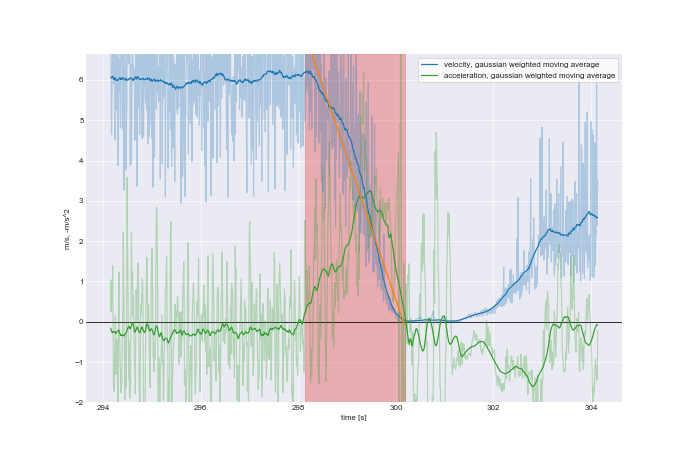

(array([ (-3.41959957,  2217.22322795, -0.81594433,   1.23613361e-51,  0.16759747,  4.773572,  1.688216,  4.36733372,  646.786187,  648.474403, 55, [10418, 10629], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.16974104, -0.17759459, -0.1854825 , ..., -0.15055564,
       -0.14360544, -0.13665046]), [])



<IPython.core.display.Javascript object>


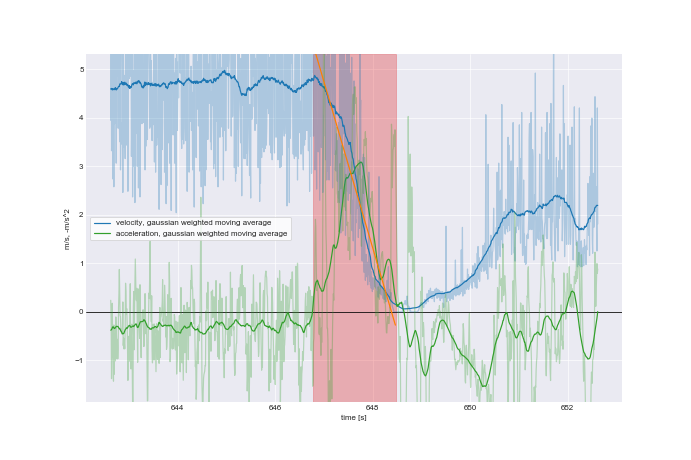

(array([ (-2.81350218,  2028.74152639, -0.89590923,   5.06220244e-101,  0.0832233,  5.5558065,  2.26428,  6.43409771,  718.931267,  721.195547, 55, [7585, 7868], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.15823922, -0.16694847, -0.17584949, ..., -0.23043787,
       -0.22301588, -0.21597143]), [])



<IPython.core.display.Javascript object>


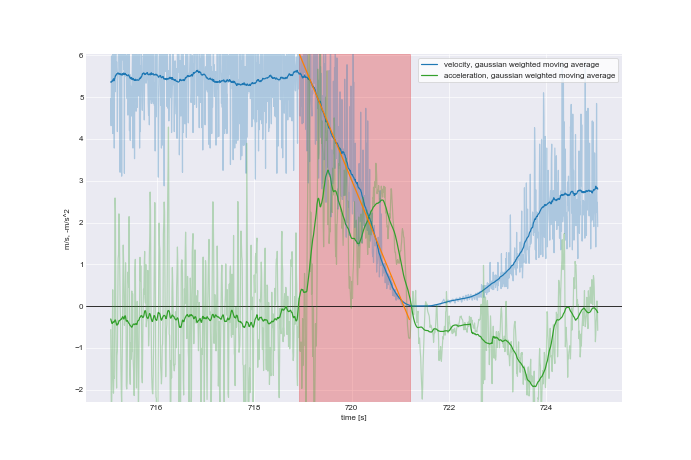

(array([ (-2.94506995,  2317.09092243, -0.90727542,   2.71118459e-98,  0.085318,  5.84127673,  2.064258,  7.20867487,  784.551515,  786.615773, 55, [6828, 7086], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.19382159, -0.20550014, -0.21872112, ..., -0.17732733,
       -0.17064485, -0.16380584]), [])



<IPython.core.display.Javascript object>


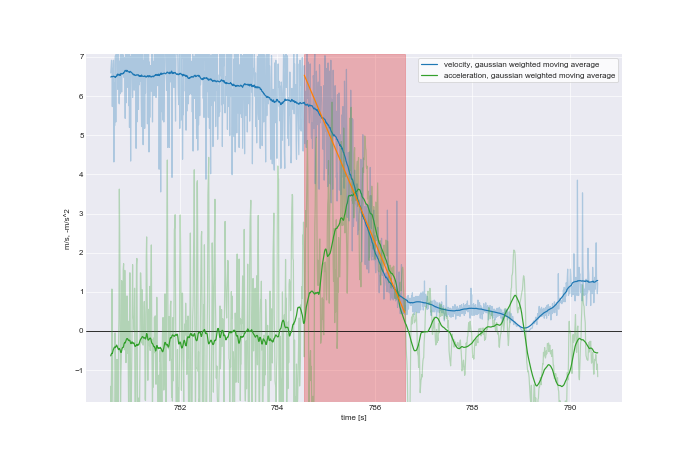

(array([ (-3.31971236,  3744.50954401, -0.85276104,   3.74412874e-76,  0.12537655,  6.1621285,  2.120266,  6.34514454,  1126.000445,  1128.120711, 55, [7244, 7509], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.17740302, -0.18552688, -0.1937499 , ..., -0.2655074 ,
       -0.25563823, -0.24531411]), [])



<IPython.core.display.Javascript object>


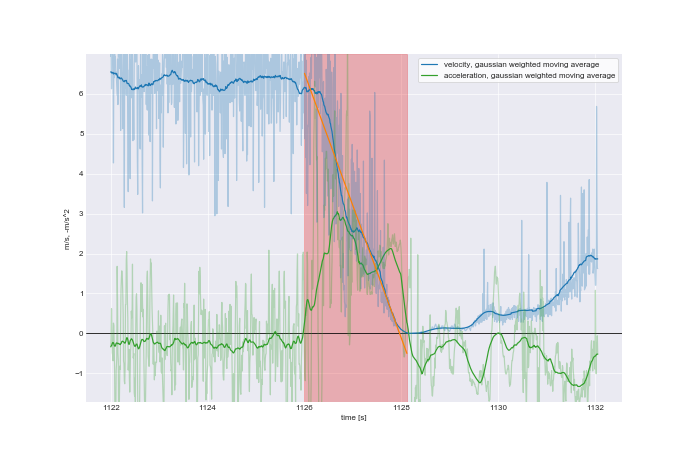

(array([ (-1.90609457,  2290.63658813, -0.93863203,   5.21764768e-112,  0.04540244,  3.40336394,  1.920244,  3.53411849,  1199.817727,  1201.737971, 55, [7640, 7880], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.23034078, -0.23778247, -0.24483387, ..., -0.17647751,
       -0.17034125, -0.16426241]), [])



<IPython.core.display.Javascript object>


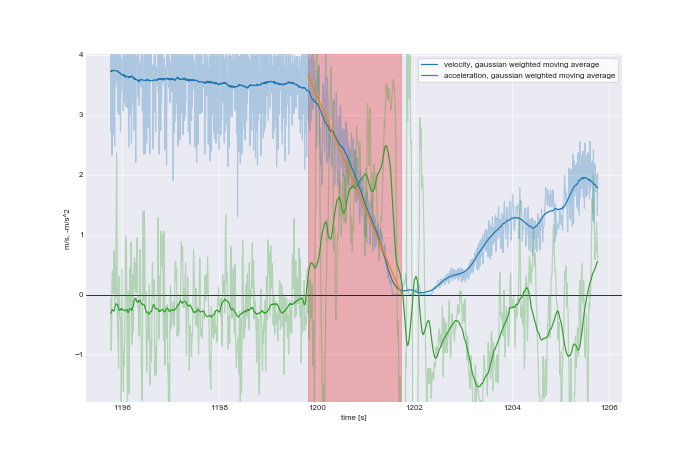

(array([ (-2.63240259,  3353.2120722, -0.94458997,   7.47921089e-173,  0.04868889,  6.22450274,  2.840358,  9.14447988,  1271.1787,  1274.019058, 55, [7334, 7689], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.17015148, -0.17746388, -0.18454773, ..., -0.12831264,
       -0.12255305, -0.11645478]), [])



<IPython.core.display.Javascript object>


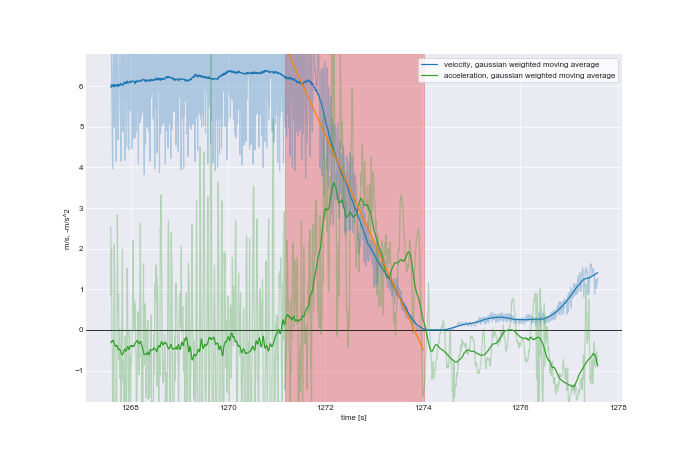

In [441]:
from antlia.trial2 import EventType
from antlia import plot_braking as braking

plt.close('all')
for trial in r.trials:
    if trial.event.type != EventType.Braking:
        continue
    
    metrics_kw = {'braking_threshold': 0.2, 'min_size': 30}
        
    m = braking.get_metrics(trial.bicycle, **metrics_kw)
    print(m)
    print()
    
    braking.plot_trial_braking_event(
        trial.bicycle, metrics_kw=metrics_kw)
    
plt.show()

In [311]:
#x, y = r.lidar.frame(250).cartesian(**cart_kw)
x, y = r.lidar.frame(lambda t: (t > 200) & (t < 250)).cartesian(**cart_kw)
print(x)
print(x.shape)
print(y)
print(y.shape)
print()
X = np.vstack((x[0].compressed(), y[0].compressed())).transpose()
#print(X)

np.zeros((3,))

import hdbscan

def lidar_object_count(lidarrec, xlim=None, ylim=None, rlim=None):
    x, y = lidarrec.cartesian(xlim, ylim, rlim)
    
    count = np.zeros((x.shape[0],))
    for i in range(x.shape[0]):
        X = np.vstack((
                x[i].compressed(),
                y[i].compressed())).transpose()
        hdb = hdbscan.HDBSCAN(
                min_cluster_size=10,
                min_samples=10,
                allow_single_cluster=True,
                metric='euclidean').fit(X)
        count[i] = max(hdb.labels_)
    return count

#count = lidar_object_count(r.lidar.frame(lambda t: (t > 200) & (t < 250)), xlim=(-10, 30), ylim=(0, 4))

[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]
(1000, 1521)
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]
(1000, 1521)

